In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import random, math, time
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
df = pd.read_csv('nlpdf.csv', encoding="latin1")

In [4]:
df.head()

,Informal,Formal
0,dear all due to the delay in ubs windows accou...,dear all due to the delay in ubs windows accou...
1,i wanna put this old dog out of its misery bef...,i would like to put this old dog out of its mi...
2,hi there want to see some nasty hot action cum...,hi there want to see some nasty hot action cum...
3,hello mark i have attached an outline that wil...,hello mark i have attached an outline that wil...
4,cst to brett r peter n tracee cc kelly h sarah...,cst to brett r peter n tracee cc kelly h sarah...


In [5]:
# Select only the required columns
selected_df = df[["Formal", "Informal"]]

# (Optional) Save to a new CSV
selected_df.to_csv("formal_to_informal.csv", index=False)

In [6]:
df = pd.read_csv("formal_to_informal.csv")

df.head()

,Formal,Informal
0,dear all due to the delay in ubs windows accou...,dear all due to the delay in ubs windows accou...
1,i would like to put this old dog out of its mi...,i wanna put this old dog out of its misery bef...
2,hi there want to see some nasty hot action cum...,hi there want to see some nasty hot action cum...
3,hello mark i have attached an outline that wil...,hello mark i have attached an outline that wil...
4,cst to brett r peter n tracee cc kelly h sarah...,cst to brett r peter n tracee cc kelly h sarah...


In [7]:
# Split: 80% train, 10% val, 10% test
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_df.to_csv("train_formal_inf.csv", index=False)
val_df.to_csv("val_formal_inf.csv", index=False)
test_df.to_csv("test_formal_inf.csv", index=False)


In [8]:
class EmailToneDataset(Dataset):
    def __init__(self, filepath, tokenizer, max_len=100):
        self.data = pd.read_csv(filepath)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        formal = "Formal: " + self.data.iloc[index]['Formal']
        informal = self.data.iloc[index]['Informal']

        source = self.tokenizer(formal, padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt")
        target = self.tokenizer(informal, padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt")

        return {
            'input_ids': source['input_ids'].squeeze(),
            'attention_mask': source['attention_mask'].squeeze(),
            'labels': target['input_ids'].squeeze()
        }


In [11]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base").to(device)


In [12]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

def train_epoch(model, dataloader):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    return total_loss / len(dataloader)




In [13]:
def evaluate_loss(model, dataloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
    return total_loss / len(dataloader)


In [14]:
train_dataset = EmailToneDataset("train_formal_inf.csv", tokenizer)
val_dataset = EmailToneDataset("val_formal_inf.csv", tokenizer)
test_dataset = EmailToneDataset("test_formal_inf.csv", tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch 1 | Train Loss: 0.3684 | Val Loss: 0.0478
Epoch 2 | Train Loss: 0.0487 | Val Loss: 0.0343
Epoch 3 | Train Loss: 0.0362 | Val Loss: 0.0282
Epoch 4 | Train Loss: 0.0300 | Val Loss: 0.0245
Epoch 5 | Train Loss: 0.0259 | Val Loss: 0.0224
Epoch 6 | Train Loss: 0.0228 | Val Loss: 0.0209
Epoch 7 | Train Loss: 0.0201 | Val Loss: 0.0184
Epoch 8 | Train Loss: 0.0182 | Val Loss: 0.0183
Epoch 9 | Train Loss: 0.0163 | Val Loss: 0.0174
Epoch 10 | Train Loss: 0.0150 | Val Loss: 0.0172
Epoch 11 | Train Loss: 0.0138 | Val Loss: 0.0176
Epoch 12 | Train Loss: 0.0126 | Val Loss: 0.0176
Epoch 13 | Train Loss: 0.0114 | Val Loss: 0.0178
Early stopping triggered at epoch 13


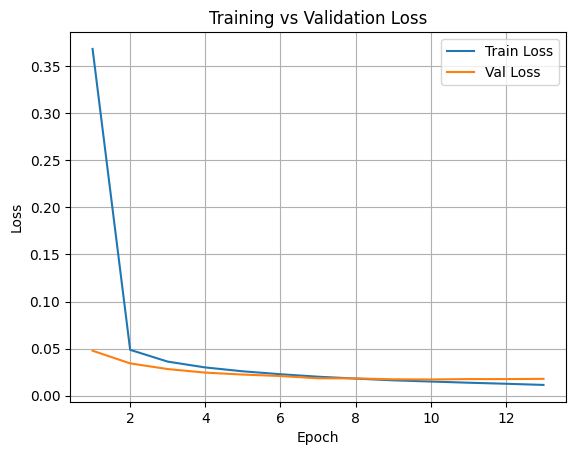

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt

train_losses = []
val_losses = []

# Early stopping parameters
best_val_loss = float('inf')
patience = 3
counter = 0

for epoch in range(50):  # You can increase this if needed
    train_loss = train_epoch(model, train_loader)
    val_loss = evaluate_loss(model, val_loader)

    train_losses.append({"epoch": epoch + 1, "loss": train_loss})
    val_losses.append({"epoch": epoch + 1, "loss": val_loss})

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Optionally save the best model
        torch.save(model.state_dict(), "outputs4/best_model.pt")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Save to CSV
os.makedirs("outputs3", exist_ok=True)
pd.DataFrame(train_losses).to_csv("outputs4/train_loss.csv", index=False)
pd.DataFrame(val_losses).to_csv("outputs4/val_loss.csv", index=False)

# Plot both
plt.plot([d['epoch'] for d in train_losses], [d['loss'] for d in train_losses], label='Train Loss')
plt.plot([d['epoch'] for d in val_losses], [d['loss'] for d in val_losses], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("outputs4/loss_comparison.png")
plt.show()

In [16]:
model.save_pretrained("outputs4/formal_informal_rewriter_model_updated")
tokenizer.save_pretrained("outputs4/formal_informal_rewriter_model_updated")

('outputs4/formal_informal_rewriter_model_updated/tokenizer_config.json',
 'outputs4/formal_informal_rewriter_model_updated/special_tokens_map.json',
 'outputs4/formal_informal_rewriter_model_updated/spiece.model',
 'outputs4/formal_informal_rewriter_model_updated/added_tokens.json')

In [18]:
def rewrite_email(text):
    input_text = "Formal: " + text
    inputs = tokenizer(input_text, return_tensors="pt", padding=True).to(device)
    outputs = model.generate(**inputs, max_length=100)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example
informal_text = "I would like to say that i want the document that i sent yesterday. I can't find it in my device"
print("Formal:", rewrite_email(informal_text))


Formal: wanna say that i want the document that i sent yesterday. I can't find it in my device


In [19]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

nltk.download('punkt')

smooth = SmoothingFunction().method4
rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)


[nltk_data] Downloading package punkt to /home/jupyter-
[nltk_data]     st125404/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [20]:
def evaluate_model(model, tokenizer, dataset, num_samples=100):
    model.eval()

    bleu_scores = []
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []

    with torch.no_grad():
        for i in range(min(num_samples, len(dataset))):
            sample = dataset[i]
            input_ids = sample['input_ids'].unsqueeze(0).to(device)
            attention_mask = sample['attention_mask'].unsqueeze(0).to(device)

            output = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=100)
            generated = tokenizer.decode(output[0], skip_special_tokens=True)

            reference = tokenizer.decode(sample['labels'], skip_special_tokens=True)

            # BLEU
            ref_tokens = nltk.word_tokenize(reference)
            gen_tokens = nltk.word_tokenize(generated)
            bleu = sentence_bleu([ref_tokens], gen_tokens, smoothing_function=smooth)
            bleu_scores.append(bleu)

            # ROUGE
            scores = rouge.score(generated, reference)
            rouge1_scores.append(scores['rouge1'].fmeasure)
            rouge2_scores.append(scores['rouge2'].fmeasure)
            rougeL_scores.append(scores['rougeL'].fmeasure)

    print(f"BLEU Score: {sum(bleu_scores) / len(bleu_scores):.4f}")
    print(f"ROUGE-1: {sum(rouge1_scores) / len(rouge1_scores):.4f}")
    print(f"ROUGE-2: {sum(rouge2_scores) / len(rouge2_scores):.4f}")
    print(f"ROUGE-L: {sum(rougeL_scores) / len(rougeL_scores):.4f}")


In [21]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

model_path = "outputs4/formal_informal_rewriter_model_updated"
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path).to(device)

model.eval()  # Set to eval mode

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [22]:
import nltk

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /home/jupyter-
[nltk_data]     st125404/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [23]:
evaluate_model(model, tokenizer, test_dataset, num_samples=100)


BLEU Score: 0.8898
ROUGE-1: 0.9482
ROUGE-2: 0.9236
ROUGE-L: 0.9482
